# Bayesian Neural Network in PyMC3
(c) 2016 by Thomas Wiecki

In [1]:
%matplotlib inline
import pymc3 as pm
import theano.tensor as T
import theano
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import datasets
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from sklearn.datasets import make_moons, make_circles, make_classification


In [2]:
X, Y = make_moons(noise=0.2, random_state=0, n_samples=1000)
X = scale(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=.5)

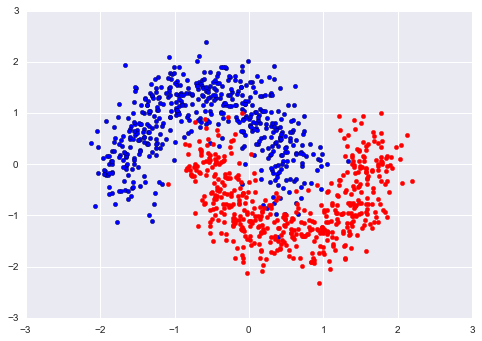

In [3]:
plt.scatter(X[Y==0, 0], X[Y==0, 1])
plt.scatter(X[Y==1, 0], X[Y==1, 1], color='r')

In [4]:
# Turn inputs and outputs into shared variables so that we can change them later

ann_input = theano.shared(X_train)
ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random weights.
init_1 = np.random.randn(X.shape[1], n_hidden)
init_2 = np.random.randn(n_hidden, n_hidden)
init_out = np.random.randn(n_hidden)
    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, 
                             shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, 
                            shape=(n_hidden, n_hidden), 
                            testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, 
                              shape=(n_hidden,), 
                              testval=init_out)
    
    # Build neural-network
    act_1 = T.tanh(T.dot(ann_input, weights_in_1))
    act_2 = T.tanh(T.dot(act_1, weights_1_2))
    act_out = T.nnet.sigmoid(T.dot(act_2, weights_2_out))
    
    out = pm.Bernoulli('out', 
                       act_out,
                       observed=ann_output)

In [28]:
with neural_network:    
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step)[5000:]

 [-----------------100%-----------------] 10000 of 10000 complete in 14.5 sec

## Predict on hold-out data

In [29]:
# Replace shared variables with testing set
# (note that using this trick we could be streaming ADVI for big data)
ann_input.set_value(X_test)
ann_output.set_value(Y_test)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

pred = ppc['out'].mean(axis=0) > 0.5

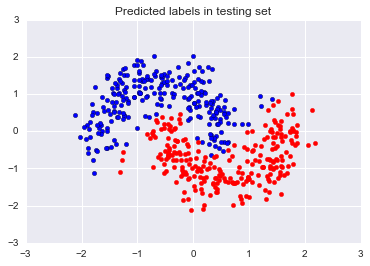

In [30]:
plt.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
plt.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
plt.title('Predicted labels in testing set')

In [31]:
print('Accuracy = {}%'.format((Y_test == pred).mean() * 100))

Accuracy = 95.39999999999999%


## Lets look at what the classifier has learned

In [32]:
grid = np.mgrid[-3:3:100j,-3:3:100j]
grid_2d = grid.reshape(2, -1).T
dummy_out = np.ones(grid.shape[1], dtype=np.int8)

In [33]:
ann_input.set_value(grid_2d)
ann_output.set_value(dummy_out)

# Creater posterior predictive samples
ppc = pm.sample_ppc(trace, model=neural_network, samples=500)

### Probability of label == 1

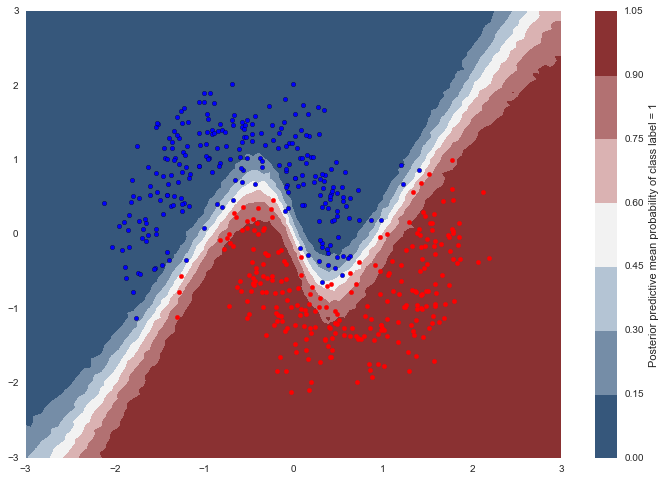

In [34]:
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
contour = ax.contourf(*grid, ppc['out'].mean(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3));
cbar.ax.set_ylabel('Posterior predictive mean probability of class label = 1')

### Uncertainty in predicted value

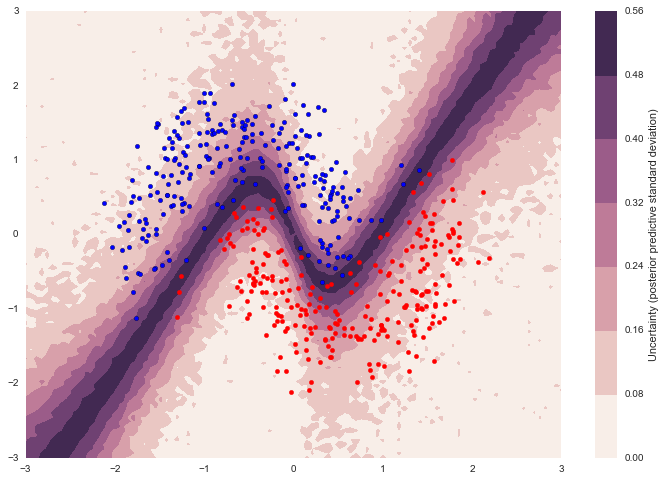

In [35]:
cmap = sns.cubehelix_palette(light=1, as_cmap=True)
fig, ax = plt.subplots(figsize=(12, 8))
contour = ax.contourf(*grid, ppc['out'].std(axis=0).reshape(100, 100), cmap=cmap)
ax.scatter(X_test[pred==0, 0], X_test[pred==0, 1])
ax.scatter(X_test[pred==1, 0], X_test[pred==1, 1], color='r')
cbar = plt.colorbar(contour, ax=ax)
_ = ax.set(xlim=(-3, 3), ylim=(-3, 3));
cbar.ax.set_ylabel('Uncertainty (posterior predictive standard deviation)')

This is really neat -- because we're in a Bayesian framework we get uncertainty in our predictions. You can see that very close to the decision boundary, our uncertainty as to which label to predict is highest.

## Variational inference with ADVI 

In [36]:
# Restore to original data
ann_input.set_value(X_train)
ann_output.set_value(Y_train)

In [37]:
with neural_network:
    # Run ADVI
    means, sds, elbos = pm.variational.advi(n=20000, accurate_elbo=True)

Iteration 0 [0%]: ELBO = -575.13
Iteration 2000 [10%]: ELBO = -239.1
Iteration 4000 [20%]: ELBO = -201.38
Iteration 6000 [30%]: ELBO = -188.81
Iteration 8000 [40%]: ELBO = -181.05
Iteration 10000 [50%]: ELBO = -169.2
Iteration 12000 [60%]: ELBO = -136.24
Iteration 14000 [70%]: ELBO = -121.37
Iteration 16000 [80%]: ELBO = -118.21
Iteration 18000 [90%]: ELBO = -121.86
Finished [100%]: ELBO = -119.77


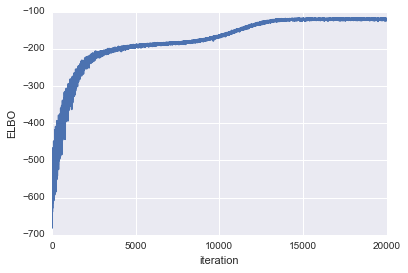

In [38]:
plt.plot(elbos)
plt.ylabel('ELBO')
plt.xlabel('iteration')

## Mini-batch ADVI for Big Data

Contributed to PyMC3 by Taku Yoshioka.

Redefine model, this shouldn't be required but couldn't solve it in time.

In [39]:
# Turn inputs and outputs into shared variables so that we can change them later
import theano.tensor as tt

ann_input = tt.matrix()
ann_input.tag.test_value = X_train
ann_output = tt.vector()
ann_output.tag.test_value = Y_train

#ann_input = theano.shared(X_train)
#ann_output = theano.shared(Y_train)

n_hidden = 5

# Initialize random but sorted starting weights.
init_1 = np.random.randn(X.shape[1], n_hidden)
init_1 = init_1[:, np.argsort(init_1.sum(axis=0))]
init_2 = np.random.randn(n_hidden, n_hidden)
init_2 = init_2[:, np.argsort(init_2.sum(axis=0))]
init_out = np.random.randn(n_hidden)
init_out = init_out[np.argsort(init_out)]

    
with pm.Model() as neural_network:
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal('w_in_1', 0, sd=1, shape=(X.shape[1], n_hidden), 
                             testval=init_1)
    
    # Weights from 1st to 2nd layer
    weights_1_2 = pm.Normal('w_1_2', 0, sd=1, shape=(n_hidden, n_hidden), 
                             testval=init_2)
    
    # Weights from hidden layer to output
    weights_2_out = pm.Normal('w_2_out', 0, sd=1, shape=(n_hidden,), 
                              testval=init_out)

    # Build neural-network
    a1 = T.dot(ann_input, weights_in_1)
    act_1 = T.tanh(a1)
    a2 = T.dot(act_1, weights_1_2)
    act_2 = T.tanh(a2)
    act_out = T.dot(act_2, weights_2_out)
    
    out = pm.Bernoulli('out', 
                       T.nnet.sigmoid(act_out),
                       observed=ann_output)

Define mini-batches and how to set them

In [40]:
minibatch_tensors = [ann_input, ann_output]
minibatch_RVs = [out]

def create_minibatch(data):
    rng = np.random.RandomState(0)
    
    while True:
        ixs = rng.randint(len(data), size=100)
        yield data[ixs]

minibatches = [
    create_minibatch(X_train), 
    create_minibatch(Y_train),
]

total_size = len(Y_train)

In [41]:
with neural_network:
    # Run advi_minibatch
    means, sds, elbos = pm.variational.advi_minibatch(
        n=40000, minibatch_tensors=minibatch_tensors, 
        minibatch_RVs=minibatch_RVs, minibatches=minibatches, 
        total_size=total_size, learning_rate=1e-2, epsilon=1.0
    )

Iteration 0 [0%]: ELBO = -221.06
Iteration 4000 [10%]: ELBO = -230.95
Iteration 8000 [20%]: ELBO = -165.57
Iteration 12000 [30%]: ELBO = -92.98
Iteration 16000 [40%]: ELBO = -70.55
Iteration 20000 [50%]: ELBO = -120.95
Iteration 24000 [60%]: ELBO = -129.75
Iteration 28000 [70%]: ELBO = -96.38
Iteration 32000 [80%]: ELBO = -137.92
Iteration 36000 [90%]: ELBO = -122.2
Finished [100%]: ELBO = -105.2


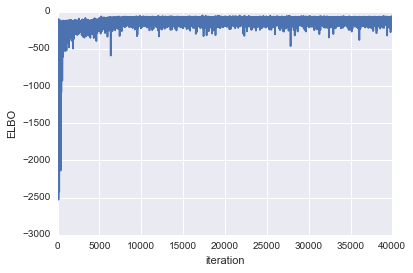

In [42]:
plt.plot(elbos)
plt.ylabel('ELBO')
plt.xlabel('iteration')